# 2.voice_verification_model.py

This model uses MFCC-based voice features to classify speakers based on their voiceprints. It includes data loading, preprocessing, feature engineering, model training (Random Forest, Logistic Regression, XGBoost), and performance evaluation.

Import Library

In [45]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder
import joblib


 Load Data

In [46]:
df = pd.read_csv("../audio_features.csv")  # Replace with your actual file path
print(df.head())


                  filename  mfcc_mean  rolloff_mean    energy
0         KG_25_Avenue.wav -23.892967   3483.395508  0.000100
1       KG_25_Avenue_3.wav -21.878180   3329.424716  0.000135
2  yes_approve_stretch.wav -27.027054   3524.677734  0.000040
3    yes_approve_pitch.wav -25.835110   4257.914062  0.000044
4    yes_approve_noise.wav -20.430970   8949.537598  0.000109


Define Training Function

In [47]:
def train_voice_model():
    df = pd.read_csv("../audio_features.csv")

    if 'filename' not in df.columns:
        raise KeyError("The 'filename' column is missing in audio_features.csv")

    # Extract label from filename
    df['label'] = df['filename'].apply(lambda x: os.path.basename(x).split('_')[0])

    # Encode label
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

    # Features
    X = df.drop(columns=['filename', 'label'])

    # Convert object columns to numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = LabelEncoder().fit_transform(X[col])

    y = df['label']

    # Smart split
    if len(df) >= len(le.classes_) * 5:
        stratify_option = y
        test_size = 0.3
    else:
        stratify_option = None
        test_size = 0.2

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=stratify_option
    )

    return X_train, X_test, y_train, y_test, le


Train and Evaluate Model

In [48]:
def train_and_evaluate(X_train, X_test, y_train, y_test, le):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    loss = log_loss(y_test, y_proba, labels=le.transform(le.classes_))

    print(f" Accuracy: {acc:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" Log Loss: {loss:.4f}")

    return model, y_pred


Plot Confusion Matrix

In [49]:
def plot_confusion(y_test, y_pred, le):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(" Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


Save Model

In [50]:
def save_model(model, le):
    os.makedirs("saved_models", exist_ok=True)
    joblib.dump(model, "saved_models/voice_model.pkl")
    joblib.dump(le, "saved_models/voice_label_encoder.pkl")
    print(" Voice model trained and saved successfully.")


Run Everything

 Accuracy: 0.5000
 F1 Score: 0.3333
 Log Loss: 0.8205


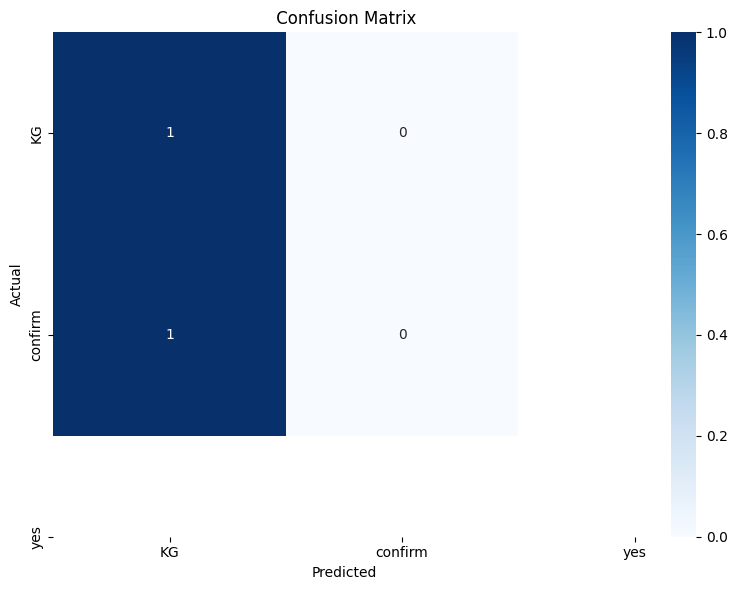

 Voice model trained and saved successfully.


In [51]:
X_train, X_test, y_train, y_test, le = train_voice_model()
model, y_pred = train_and_evaluate(X_train, X_test, y_train, y_test, le)
plot_confusion(y_test, y_pred, le)
save_model(model, le)
